In [1]:
!pip3 install gensim --user --upgrade
!pip3 install keras --upgrade
!pip3 install pandas --upgrade


Requirement already up-to-date: gensim in c:\users\xkhg78\appdata\local\programs\python\python37\lib\site-packages (3.8.1)


You should consider upgrading via the 'c:\users\xkhg78\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: keras in c:\users\xkhg78\appdata\local\programs\python\python37\lib\site-packages (2.3.1)


You should consider upgrading via the 'c:\users\xkhg78\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\xkhg78\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\~andas\\io\\msgpack\\_packer.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\xkhg78\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [171]:
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import gensim
nltk.download('punkt')
from sklearn import svm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xkhg78\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", names=["label", "ids", "date", "flag", "user", "text"]) 
data = data.drop(range(1600000)[20000:-20000])

# DATA EXPLORATION

## Dataset details:

#### target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

#### ids: The id of the tweet

#### date: the date of the tweet

#### flag: The query. If there is no query, then this value is NO_QUERY.

#### user: the user that tweeted

#### text: the content of the tweet


In [5]:
print("Dataset size:", len(data))

Dataset size: 40000


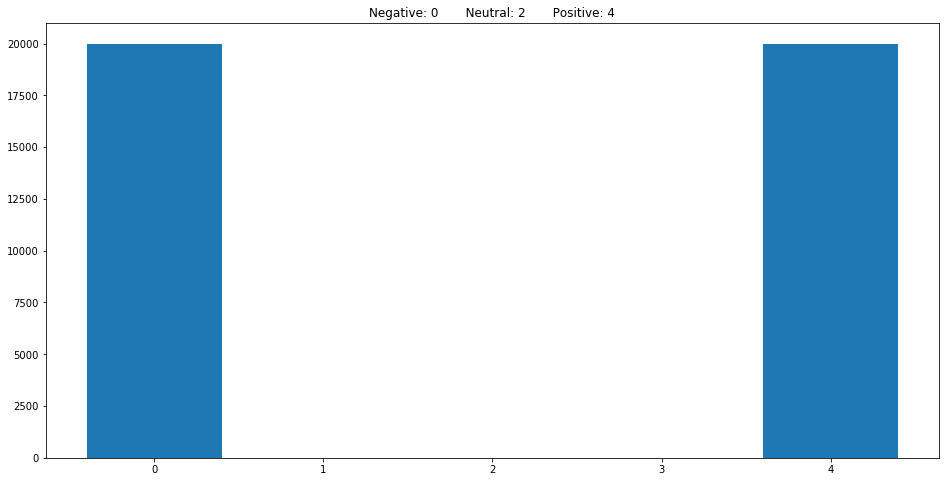

In [6]:
target_cnt = Counter(data.label)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('''Negative: 0       Neutral: 2       Positive: 4''')
print()

In [159]:
re_clean_symbols = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def normalizeWords(sentance):
    wordnet_lemmatizer = WordNetLemmatizer()
    sentance = re.sub(re_clean_symbols, ' ', str(sentance).lower()).strip()
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(sentance) 
    filtered_sentence = [wordnet_lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words] 
    return ' '.join(filtered_sentence)

data.text = data.text.apply(lambda x: normalizeWords(x))

data.loc[data['label'] == 4]

,label,ids,date,flag,user,text
1580000,4,2190011386,Tue Jun 16 01:30:56 PDT 2009,NO_QUERY,Happysodme,well done old timer getting breakfast pink jim...
1580001,4,2190011394,Tue Jun 16 01:30:56 PDT 2009,NO_QUERY,lovelywings14,haha thanks let know work okay
1580002,4,2190011406,Tue Jun 16 01:30:57 PDT 2009,NO_QUERY,Storm_rider_uk,good morning everyone beautiful morning
1580003,4,2190011433,Tue Jun 16 01:30:57 PDT 2009,NO_QUERY,loveeu4ever,reunited friend imma missed sooo much
1580004,4,2190011510,Tue Jun 16 01:30:58 PDT 2009,NO_QUERY,strybe,something wrong right twitpic lol
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interview
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask detail
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...


In [8]:
def countWords(sentences, divider=None):
    word_to_freq = {}
    for sen in sentences:
        for word in sen.split(' '):
            d = 1
            if divider is not None:
                d = divider[word]
            if word not in word_to_freq:
                word_to_freq[word] = 0
            else:
                word_to_freq[word] += 1/d
    return word_to_freq

positive_sentances = data.loc[data['label'] == 4].text
negative_sentances = data.loc[data['label'] == 0].text

words_freq = countWords(data.text)
pos_words_freq = countWords(positive_sentances, words_freq)
neg_words_freq = countWords(negative_sentances, words_freq)

data_to_table = {}
for key in words_freq:
    pos = pos_words_freq[key] if key in pos_words_freq else 0
    neg = neg_words_freq[key] if key in neg_words_freq else 0
    data_to_table[key] = [pos, neg]
    
pd.DataFrame.from_dict(data_to_table, orient='index', columns = ['Positive', 'Negative'])

,Positive,Negative
awww,0.339130,0.652174
bummer,0.106383,0.872340
shoulda,0.000000,0.875000
got,0.443760,0.555680
david,0.619048,0.357143
...,...,...
amaru,0.000000,0.000000
shakur,0.000000,0.000000
thenspcc,0.000000,0.000000
sparkscharity,0.000000,0.000000


# Data preparation

In [167]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=43)
print("Train data size:", len(X_train))
print("Test data size:", len(X_test))

8483       would really like good tracking info girlie ea...
1594625                                                route
13328      trying cry haiir stupid gay ruin dont ever go ...
1584380                                    season 1 starting
1596483                      yayyyy glad u loving sleep good
                                 ...                        
5307                   locked outlook account 3rd time 3 day
1585233     hey johann ooh crap read tweet lol see craziness
18448                                            woops wrong
19776        luck whatsoever mcdonalds monopoly sticker week
14148                  lol nastyyy nothing wrong fan someone
Name: text, Length: 32000, dtype: object
Train data size: 32000
Test data size: 8000


In [169]:
cv = CountVectorizer()
termMatrix = cv.fit_transform(X_train['text'])
BOW_arr = termMatrix.toarray()
BOW = pd.DataFrame(data=BOW_arr,columns=cv.get_feature_names())
BOW

,00,000,0000,00009,000th,002,0055gb,007,00a,00am,...,zurairi,zurich,zwame,zyngapoker,zyrtec,zz,zzz,zzzz,zzzzzz,zzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# train the model

In [ ]:
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(BOW, y_train)

In [ ]:
doc = [t.split() for t in X_train.text] 
doc

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [ ]:
w2v_model

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\xkhg78\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\sentiwordnet.zip.


AttributeError: 'zip' object has no attribute 'first'